In [1]:
%load_ext autoreload
%autoreload 2

import gym

from src.environments.MultiEnv import MultiEnv

from matplotlib import pyplot as plt
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
class Actor(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.model(x)
    
class Critic(nn.Module):
    """Some Information about ActorCritic"""
    def __init__(self, state_size):
        super(Critic, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

class Memory:
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def add(self, log_prob, value, done, reward):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)
        self.rewards.append(reward)
    
    def clear(self):
        self.log_probs = []
        self.values = []
        self.dones = []
        self.rewards = []
    
    def __len__(self):
        return len(self.log_probs)

In [3]:
def update(mem, next_state):
    q_values = []

    # Do not add this one as it's for the next state
    running_reward = critic(torch.tensor(next_state).float()).squeeze(dim=1)

    for reward, done in zip(reversed(mem.rewards), reversed(mem.dones)):
        mask = torch.from_numpy(np.array(1 - done)).float()
        reward = torch.from_numpy(np.array(reward)).float()

        running_reward = (reward + gamma * running_reward) * mask
        q_values.append(running_reward)

    values = torch.stack(mem.values).squeeze(dim=2)
    log_probs = torch.stack(mem.log_probs)
    q_values = torch.stack(q_values)

    advantage = q_values - values

    critic_loss = torch.pow(advantage, 2).mean()
    actor_loss = (-log_probs * advantage).sum(dim=0).mean()

    critic_optim.zero_grad()
    critic_loss.backward(retain_graph=True)
    critic_optim.step()

    actor_optim.zero_grad()
    actor_loss.backward(retain_graph=True)
    actor_optim.step()

In [4]:
env_name = "LunarLander-v2"

env = gym.make(env_name)

state_space = env.observation_space.shape[0]
action_space = env.action_space.n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
win_condition = 200

num_episodes = 2000
bootstrap_len = 5

gamma = 0.99

In [6]:
mem = Memory()

actor = Actor(state_space, action_space)
critic = Critic(state_space)

actor_optim = optim.Adam(actor.parameters(), lr=5e-4)
critic_optim = optim.Adam(critic.parameters(), lr=5e-3)

In [7]:
env = MultiEnv(env_name, 8)

score_log = []
average_score_log = []
running_scores = deque(maxlen=100)

Process Process-5:
Process Process-8:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/darylrodrigo/Desktop/rl_lib/src/environments/MultiEnv.py", line 15, in worker
    cmd, msg = conn.recv()
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Process Process-6:
  File

In [8]:

for i in range(num_episodes):
    state = env.reset()
    steps = 0
    score = 0
    
    while True:
        steps += 1

        value = critic(torch.tensor(state).float())
        logits = F.softmax(actor(torch.tensor(state).float()))

        probabilities = Categorical(logits)
        action = probabilities.sample()
        log_probs = probabilities.log_prob(action)

        next_state, reward, done, _ = env.step(action.numpy())
        score += reward

        mem.add(log_probs, value, done, reward)

        if (done.any() or steps % bootstrap_len == 0):
            update(mem, next_state)
            mem.clear()
        
        if done.any():
            break
        
        state = next_state

    score_log.append(score[0])
    running_scores.append(score[0])
    average_score_log.append(np.mean(running_scores))
    
    print("\r Episode: {}\tAverage Score {:.3f}\tReward: {:.3f}".format(i, np.mean(running_scores), score[0]), end="")
    if (i % 50 == 0):
        print("\r Episode: {}\tAverage Score {:.3f}\tReward: {:.3f}".format(i, np.mean(running_scores), score[0]))

    if np.mean(running_scores) > win_condition:
        print("Environment Solved!")
        break

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


 Episode: 0	Average Score -14.159	Reward: -14.159
 Episode: 50	Average Score -57.247	Reward: 22.93506
 Episode: 100	Average Score -35.498	Reward: -17.066
 Episode: 150	Average Score 2.988	Reward: 27.570283
 Episode: 200	Average Score 19.976	Reward: 49.8362
 Episode: 250	Average Score 33.220	Reward: 75.8426
 Episode: 300	Average Score 48.985	Reward: -40.936
 Episode: 350	Average Score 54.005	Reward: 47.59307
 Episode: 400	Average Score 50.949	Reward: 41.5323
 Episode: 450	Average Score 48.417	Reward: 112.320
 Episode: 500	Average Score 54.868	Reward: 62.4262
 Episode: 550	Average Score 62.924	Reward: 45.6995
 Episode: 600	Average Score 69.941	Reward: 57.9819
 Episode: 650	Average Score 74.706	Reward: 94.9535
 Episode: 700	Average Score 71.652	Reward: 112.618
 Episode: 750	Average Score 76.199	Reward: 44.5247
 Episode: 800	Average Score 77.276	Reward: 135.970
 Episode: 850	Average Score 68.561	Reward: 53.3633
 Episode: 900	Average Score 71.090	Reward: 17.8780
 Episode: 950	Average Score 

KeyboardInterrupt: 

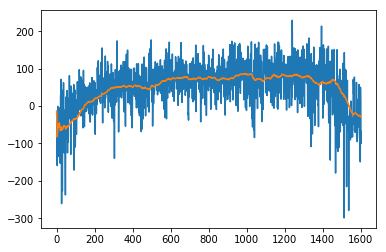

In [9]:
plt.plot(score_log)
plt.plot(average_score_log)

In [10]:
import gym
trained_env = gym.make(env_name)
for i_episode in range(3):
    input()
    observation = trained_env.reset()
    for t in range(1500):
        trained_env.render()
        logits = F.softmax(actor(torch.tensor(observation).float()))
        
        probabilities = Categorical(logits)
        action = probabilities.sample()
        
#         print(torch.stack([action]))

        observation, reward, done, info = trained_env.step(action.numpy())
        
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
trained_env.close()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Episode finished after 1000 timesteps

Episode finished after 1000 timesteps

Episode finished after 1000 timesteps
